# Homework 1

Yi Zuo
08/10/2020

## TOC:

* [0. Tutorial to Google Colab](#prep)
* [1. Introduction to homework 1](#intro)
* [2. Lasso as a benchmark](#lasso)
* [3. Neural networks](#nn)
* [4. Grading](#grading)
    * [4.1 B](#b)
    * [4.2 A](#a)
    * [4.3 F](#f)

## 0. Tutorial to Google Colab <a name="prep"></a>
Below are the steps needed to create a Google Colab notebook with GPU capability.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. Introduction to homework 1 <a name="intro"></a>

In this homework, you are asked to understand the difference between statistical modeling and deep learning modeling, get familiarized with building simple neural networks model, understand bias-variance tradeoff, and predict the outcome using the best model selected.

First, let's install modules not already installed by Google Colab. 

In [ ]:
! pip install torch_utils

You need to restart runtime here.

In [ ]:
%cd gdrive/My\ Drive/Colab\ Notebooks/hw1

/content/gdrive/My Drive/Colab Notebooks/hw1


In [ ]:
# save me from using display function every time I have multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# import modules
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch_utils import AverageMeter
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import inf

## 2. Lasso as a benchmark <a name="lasso"></a>





In [ ]:
# import training data set
train_data = pd.read_csv('data/train.csv') # 1022 by 258

# get training set: n = 800
train_x = train_data.loc[train_data['index']=="training",train_data.columns[2:258] ]
train_y = train_data.loc[train_data['index']=="training",'SalePrice']

# get validation set: n = 222
validation_x = train_data.loc[train_data['index']=="validation",train_data.columns[2:258] ]
validation_y = train_data.loc[train_data['index']=="validation",'SalePrice']

# run cross-validated lasso
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(train_x, train_y)

# run lasso at best lambda
lasso = Lasso(max_iter = 10000, normalize = True)
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(train_x, train_y)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
        max_iter=100000, n_alphas=100, n_jobs=None, normalize=True,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

Lasso(alpha=72.35603144189001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

Lasso(alpha=72.35603144189001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
# generate predictions for the validation set
y_out = lasso.predict(validation_x)

# calculate rmse in validation set
'rmse in the validation set: '+str(round(math.sqrt(((validation_y - y_out).pow(2)).mean()),3) ) # 37120

'rmse in the validation set: 37120.641'

Text(0.5, 0, 'Targeted y')

Text(0, 0.5, 'Modeled y')

(100000.0, 600000.0)

(100000.0, 600000.0)

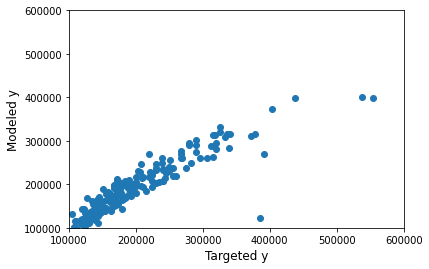

In [ ]:
# plot prediction calibration
plt.plot(validation_y,y_out, 'o')
plt.xlabel('Targeted y', fontsize=12)
plt.ylabel('Modeled y', fontsize=12)
plt.ylim(1e5,6e5)
plt.xlim(1e5,6e5)
plt.show()

## 3. Neural network <a name="nn"></a>

Data preparation

In [ ]:
# import data
train_data = pd.read_csv('data/train.csv') # 1022 by 259
test_data = pd.read_csv('data/prediction.csv') # 438 by 258

to_use = list(range(2,258))

# training set: n = 800
train_x = train_data.loc[train_data['index']=="training",train_data.columns[to_use] ]
train_min = train_x.min()
train_max = train_x.max()

train_x = (train_x - train_min) / (train_max - train_min) # make 0-1 transformation
train_x = train_x.fillna(0)

train_X = torch.tensor(train_x.values).float()

train_y = torch.tensor(train_data.loc[train_data['index']=="training",'SalePrice'].values).float().view(-1,1)
train_Y = train_y/1e2 # divide the original price by 100 for better prediction

# validation set
validation_x = train_data.loc[train_data['index']=="validation",train_data.columns[to_use] ]

validation_x = (validation_x - train_min) / (train_max - train_min) # use training data to make 0-1 transformation

validation_x = validation_x.fillna(0)
validation_x[validation_x==inf] = 0
validation_X = torch.tensor(validation_x.values).float()

validation_y = torch.tensor(train_data.loc[train_data['index']=="validation",'SalePrice'].values).float().view(-1,1)
validation_Y = validation_y/1e2 # divide the original price by 100 for better prediction

# prediction set
test_x = test_data.iloc[:,[x - 1 for x in to_use]]
test_x = (test_x - train_min) / (train_max - train_min)
test_x = test_x.fillna(0)
test_x[test_x==inf] = 0
test_X = torch.tensor(test_x.values).float()


Define the neural networks model

In [ ]:
device = torch.device("cuda")
# device = torch.device("cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} 
# prepare training data loader
train_ds = TensorDataset(train_X,train_Y)
validate_ds = TensorDataset(validation_X,validation_Y)

batch_size = 8
train_dl = DataLoader(train_ds, batch_size, shuffle=True,**kwargs)

validate_dl = DataLoader(validate_ds, batch_size, shuffle=True,**kwargs)

# define model
class bmodel(nn.Module):
    def __init__(self, input_d, hidden_d, output_d):
        super().__init__()
        self.fc1 = nn.Linear(input_d,hidden_d)
        self.fc2 = nn.Linear(hidden_d,output_d)
        self.dropout1 = nn.Dropout(0.5)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.dropout1(out)
        out = self.fc2(out)
        return out

# define dimensions
input_d = len(to_use)
hidden_d = 512
output_d = 1

# set up the model
model = bmodel(input_d, hidden_d, output_d).to(device)

# define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5)

# define loss function
loss_fn = F.mse_loss

# define the training function
def train(train_loader,model,device,loss_fn,opt):
    model.train()

    losses = AverageMeter('Loss', math.ceil(train_X.shape[0]/batch_size),':.4f')

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        
        inputs, targets = inputs.to(device), targets.to(device)
        
        # generate predictions
        pred = model(inputs)
        loss = loss_fn(pred, targets)

        # record loss
        losses.update(loss.data.item())

        # perform gradient descent
        opt.zero_grad()
        loss.backward()
        opt.step()

    return(losses.avg)

# define the validation function
def validate(val_loader, model, device, loss_fn):
    model.eval()
    with torch.no_grad():
        losses = AverageMeter('Loss',math.ceil(validation_X.shape[0]/batch_size),':.4f')

        for batch_idx, (inputs,targets) in enumerate(val_loader):
            
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs , targets )

            losses.update(loss.data.item())

    return losses.avg

# define the main function
def fit(num_epochs, model, loss_fn, opt):

    best_loss = 1e9
    is_best = False
    out_train_loss = []
    out_validate_loss = []

    for epoch in range(1,num_epochs+1):
        train_loss = train(train_dl,model,device,loss_fn,opt)
        validation_loss = validate(validate_dl, model,device, loss_fn)

        is_best = validation_loss < best_loss
        best_loss = min(validation_loss,best_loss)

        out_train_loss.append(train_loss)
        out_validate_loss.append(validation_loss)

        if is_best:
            torch.save(model.state_dict(), 'data/best_nn.pt')

        if epoch % 50 == 0:
            print("[%d/%d] training loss: %0.3f, validation loss: %.3f"
                  % (epoch,num_epochs,train_loss,validation_loss))

    print("Best validation loss: %.03f" % (best_loss))
    return out_train_loss, out_validate_loss



In [ ]:
out_train_loss, out_validate_loss = fit(500, model, loss_fn, opt)

[50/500] training loss: 64427.676, validation loss: 134857.879
[100/500] training loss: 51589.590, validation loss: 102296.885
[150/500] training loss: 40242.015, validation loss: 103445.328
[200/500] training loss: 32890.162, validation loss: 106011.670
[250/500] training loss: 36888.496, validation loss: 92633.424
[300/500] training loss: 33045.694, validation loss: 119701.870
[350/500] training loss: 28848.103, validation loss: 101257.753
[400/500] training loss: 23969.301, validation loss: 111242.528
[450/500] training loss: 26288.615, validation loss: 101836.515
[500/500] training loss: 27146.865, validation loss: 105297.090
Best validation loss: 90097.566


Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Loss')

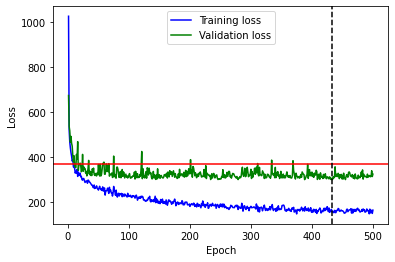

In [ ]:
# plot the training and validation loss: rmse
plot_data = {'Epoch': list(range(1,501)),
             'TrainLoss': [math.sqrt(x) for x in out_train_loss],
             'ValidateLoss': [math.sqrt(x) for x in out_validate_loss] }

plot_data = pd.DataFrame(plot_data)

# find the best epoch
index_min = plot_data['ValidateLoss'].idxmin()

# plot
plt.plot('Epoch','TrainLoss',data=plot_data,color="blue",label='Training loss')
plt.plot('Epoch','ValidateLoss',data=plot_data,color="green",label='Validation loss')
plt.axhline(y=371, color='red', linestyle='-')
plt.axvline(x=index_min+1, color='k', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot the prediction calibration

In [ ]:
# prediction in the validation set
model.load_state_dict(torch.load('data/best_nn.pt'))
model.eval()
with torch.no_grad():
    preds = model(validation_X) * 1e2

<All keys matched successfully>

bmodel(
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)

In [ ]:
preds

RuntimeError: ignored

In [ ]:
math.sqrt(mean_squared_error(validation_y, preds)) 

TypeError: ignored

In [ ]:
preds.size()
preds.cpu()

torch.Size([222, 1])

RuntimeError: ignored

<All keys matched successfully>

bmodel(
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)

31739.240570624876

Text(0.5, 0, 'Targeted y')

Text(0, 0.5, 'Modeled y')

(100000.0, 800000.0)

(100000.0, 800000.0)

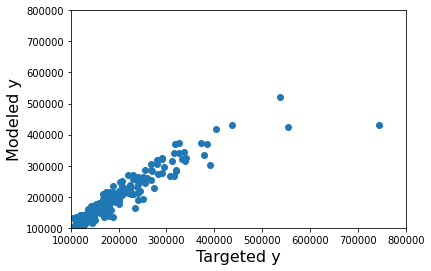

In [ ]:
# prediction in the validation set
model.load_state_dict(torch.load('data/best_nn.pt'))
model.eval()
with torch.no_grad():
    preds = model(validation_X) * 1e2

# rmse
math.sqrt(mean_squared_error(validation_y, preds)) # 29691

# calibration plot of the validation set
plt.plot( (validation_y).detach().numpy(), preds.detach().numpy(), 'o')
plt.xlabel('Targeted y', fontsize=16)
plt.ylabel('Modeled y', fontsize=16)
plt.ylim(1e5,8e5)
plt.xlim(1e5,8e5)
plt.show()


Make prediction in the test set

In [ ]:
# predict in the prediction set
model.eval()
with torch.no_grad():
    output = model(test_X)*1e2

# output the prediction
out = {'Id': test_data.iloc[:,0],
       'SalePrice': output.squeeze().tolist()}

out_d = pd.DataFrame(out)

out_d.to_csv("data/sample_nn_test.csv",index=False)


bmodel(
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
)

## 4. Grading <a name="grading"></a>

When you submit the homework, please upload  

1) your Colab notebook either in its original `ipynb` format, or `pdf` (preferred) 

2) your prediction data using Neural Networks in `csv` format. The `csv` file contains two columns, where the first column is *Id*, and the other column is *SalePrice*. Name the file "FirstnameLastname.csv", for example, "YiZuo.csv"

Your homework will be graded A, B, or F.

### 4.1 B <a name="b"></a>

* Follow along the template, and get all outputs 

### 4.2 F <a name="f"></a>

* Fail to submit homework on time, or  

* Fail to reproduce all the results from template  

### 4.3 A <a name="a"></a>

* Follow along the template, fine-tune the Neural Networks model, and the prediction MSE is 5% lower than that from the template  

* If you decide to fine-tune the model, please make it explicit where you made the changes.  